In [172]:
import numpy as np
from numpy import dot, zeros, eye, isscalar, shape
import scipy.stats as ss
import numpy.linalg as linalg
from copy import deepcopy
import itertools
import random
from matplotlib import pyplot as plt
# from scipy.stats import multivariate_normal

In [173]:
class KCF_main:
    
    def __init__(self,dim_x,numnodes,eps, A, x, P, Q, graphs, actions):
        
        self.dim_x = dim_x
        
        self.ownpriors = []
        self.ownposts = []
        # could use below as TPM across graphs but for now they are randomly obtained
      # self.G_tpm = G_tpm
        
        # the possible graphs
        self.graphs = graphs # the graphs are the states
        
        # system A and Q
        
        self.A = A
        self.Q = Q
        
        # fixing initial x0 and P0 for the real system
        
        self.x = x
        self.P = P
        
        self.numnodes = numnodes
        
        
        # adjacency matrix of the graph
        self.G = zeros((dim_x,dim_x))
        
        
        self.allnodes = []
        self.time = 0
        self.nextid = 0
        
        
        # update parameter for all the nodes
        self.eps = eps
        
        self.actions = actions # various errors that can be injected into each node at an instant
        
        self.priors = []
        self.posts = []
    
    def reset(self,dim_x,numnodes,eps, A, x, P, Q, graphs, actions):
        self.dim_x = dim_x
        self.graphs = graphs
        self.A = A
        self.Q = Q
        self.G = zeros((dim_x,dim_x))
        self.x = x
        self.P = P
        self.numnodes = numnodes
        self.allnodes = []
        self.priors = []
        self.posts = []
        self.time = 0
        self.nextid = 0
        
    # required, provide listQ and listR to save as Q and R matrices of the nodes
    # also required is the initial adjacency matrix G
    def create_nodes(self, G, listQ, listR, listH):
        
        for i in range(self.numnodes):
            node = KCF_node(self.dim_x, self.nextid, self.eps, self.A, self.P, listQ[i], listR[i], listH[i])
            self.nextid = self.nextid + 1
            self.allnodes.append(node)
            
        self.G = np.array(G)
    
    # does it ensure infinitely many occurrences of each (graph) state?
    def update_graph(self):
        # print(self.graphs)
        idx = random.randint(0,len(self.graphs)-1)
        self.G = self.graphs[idx]
    
    # require the observation z for this
    # and the injection e
    def single_step(self,e):
        for i in range(len(self.allnodes)):
            
            self.allnodes[i].set_nbrs(self.G)
            
            # note the observation
            z_curr = dot(self.allnodes[i].H,self.x) + ss.multivariate_normal.rvs(cov=self.allnodes[i].R)
            
            
            
            self.allnodes[i].prior(z_curr + e[i])
            self.allnodes[i].update(self.allnodes)
            
            self.priors.append(self.allnodes[i].x_prior)
            self.posts.append(self.allnodes[i].x_post)
        
        
        
        self.update_graph()
        self.time = self.time + 1
        
        self.ownpriors.append(self.x)
        # updates the true state as well by x = Ax + w (w ~ N(0,Q))
        self.x = dot(A,self.x) + ss.multivariate_normal.rvs(cov=self.Q)
        self.ownposts.append(self.x)

In [174]:
class KCF_node:
    
    # dim_x is the dimension of the state, ID is the unique id assigned to it, eps is related to how x updates
    
    def __init__(self, dim_x, ID, eps,A, P, Q, R, H):
        
        self.nbrs = []
        
        self.id = ID # id is the zero indexed identifying value for every node in a particular KCF. it corresponds to their
                     # occurrence in the adjacency matrix of G
        
        self.x = zeros((dim_x, 1)) # state
        self.P = P # cov x
        self.Q = Q # measurement error noise = cov(w)
        
        self.A = A # update matrix of system
        
        self.H = H # observation matrix
        self.z = zeros((dim_x, 1)) # observation = Hx + v
        self.R = R # measurement observation noise = cov(v)
        
        self.u = zeros((dim_x,1)) # info vector
        self.U = eye(dim_x) # info noise
        
        self.y = zeros((dim_x, 1)) # fused info vector
        self.S = eye(dim_x)
        
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()
        
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        
        self.eps = eps
        
        self.inv = np.linalg.inv
        
    
    def info(self):
        return self.u, self.U, self.x
    
    
    # G is the adjacency matrix at time t
    def set_nbrs(self,G):
        self.nbrs = np.where(G[self.id] == 1)[0]
        # print(self.nbrs)
        # print(self.nbrs[0])
        
        
    # all nodes contains all the (instances) nodes in this particular KCIF
    # z is the observation that this node receives (z_{k} for node k, that too could have error involved)
    def prior(self, z):
        
        # saving prior estimate at time t
        self.x_prior = self.x.copy()
        self.P_prior = self.P.copy()
        
    
        # information vector and matrix for node i
        self.u = dot(self.H.T, dot(self.inv(self.R),z))
        
        # print(self.u.shape)
        
        #u = self.u.reshape(2,1)
        
        self.u = self.u.reshape((self.u.shape[0], 1))
        
        #print(self.u.shape)
        
        
        self.U = dot(self.H.T, dot(self.inv(self.R), self.H))
        
    def update(self, allnodes):
        # to fuse info vector and matrix we first include the self u and U, then we add the values from the neighboring nodes
        self.y = self.u 
        self.S = self.U 
        
        
        
        nbr_info = []
        
        # print(self.y.shape)
        
        for j in range(len(self.nbrs)):
            idx = self.nbrs[j]
            info = allnodes[idx].info()
            
            self.S = np.add(self.S, info[1])
            nbr_info.append(info[2])
            
            # print(info)
            
            self.y = np.add(self.y, info[0])
        
        
        # setup for update
        Mi = self.inv(self.inv(self.P) + self.S)
        P_norm = np.linalg.norm(self.P,ord='nuc')
        gamma = self.eps/(P_norm + 1)
        
        
        # x hat update. this is the final estimate at this time step
        # print(nbr_info)
        # print(np.stack(nbr_info,axis = 0))
        
        
        # print((self.x).shape)
        
        # print(nbr_info)
        
        diff = np.zeros((2,1))
        
        # print(diff.shape)
        
        for k in range(len(nbr_info)):
            diff = np.add(nbr_info[k], (-1)*self.x)
            
       
        # print(type(self.y))
        
        
        
        self.x = np.add(self.x, dot(Mi,(np.add(self.y, (-1)*dot(self.S,self.x)))) + gamma*dot(self.P,diff))
        
        
        # print(self.x.shape)
        
        # now update P 
        # this is the P estimate as this time step
        self.P = self.A@self.P@self.A.T
        self.P = np.add(self.P, self.Q)
        
        
        # saving post estimate at time t
        self.x_post = self.x.copy()
        self.P_post = self.P.copy()
        # print(self.x.shape)
        # transform into prior for next state
        self.x = dot(self.A, self.x)
        
        # print(self.x.shape)

In [262]:
x0 = np.array([5,5],np.int32)
n = 3
dim_x = 2
P0 = np.array([[10,0],[0,10]],np.int32)
A0 = np.array([[0,-2],[2,0]],np.int32)
A = np.eye(2) + (0.01)*A0 + (0.0001)*dot(A0,A0) + (0.000001)*dot(A0,dot(A0,A0))
# A = np.eye(2)
eps = 0.0001
Q = np.array([[25*0.01,0],[0,25*0.01]],np.int32)


graphs = np.array([[[0,1,1],[1,0,1],[1,1,0]],[[0,1,0],[1,0,0],[0,0,0]],[[0,0,1],[0,0,0],[1,0,0]],[[0,0,0],[0,0,1],[0,1,0]]])

actions = np.array([list(itertools.permutations([1,0,-1]))])
# actions.append(np.array(list(itertools.permutations([-1,1,0]))))
actions= np.append(actions, np.array([list(itertools.permutations([-1,0,0]))]))
actions= np.append(actions, np.array([list(itertools.permutations([1,0,0]))]))
actions= np.append(actions, np.array([list(itertools.permutations([1,1,0]))]))
actions= np.append(actions, np.array([list(itertools.permutations([-1,-1,0]))]))
actions= np.append(actions, np.array([list(itertools.permutations([-1,1,1]))]))
actions= np.append(actions, np.array([list(itertools.permutations([-1,-1,1]))]))
actions= np.append(actions, np.array([[1,1,1]]))
actions= np.append(actions, np.array([[-1,-1,-1]]))
actions= np.append(actions, np.array([[0,0,0]]))


actions = actions.reshape(45, 3)
actions = np.unique(actions,axis=0)
# print(actions.shape)
print(type(graphs))
# print(graphs[0][0])

<class 'numpy.ndarray'>


In [263]:
kcf = KCF_main(dim_x,n,eps,A,x0,P0,Q,graphs,actions)
print(kcf.nextid)

0


In [264]:
listQ = np.array([[[3,0],[0,3]],[[5,0],[0,5]],[[1,0],[0,1]]])
listR = np.array([[[1,0],[0,1]],[[3,0],[0,3]],[[2,0],[0,2]]])
listH = np.array([[[1,0],[0,1]],[[1,0],[0,0]],[[0,0],[0,1]]])
init_G = graphs[0]

In [265]:
kcf.create_nodes(init_G, listQ, listR, listH)

In [266]:
iters = 0
e = np.array([0,0,0])



max_iters = 2000

while(iters < max_iters):
    kcf.single_step(e)
    iters = iters + 1

In [267]:
print(np.array(kcf.priors).shape)
prior_values = np.array(kcf.priors).reshape((max_iters,3,2,1))


(6000, 2, 1)


In [268]:
node_1_priors = np.array([row[0] for row in prior_values])
node_2_priors = np.array([row[1] for row in prior_values])
node_3_priors = np.array([row[2] for row in prior_values])



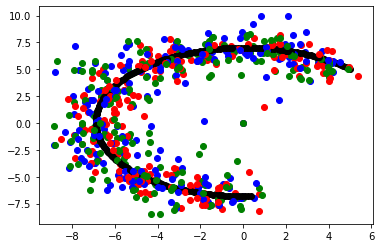

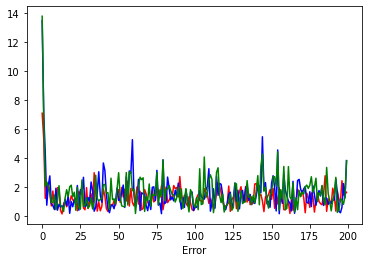

In [279]:
actual_x = np.array(kcf.ownpriors)
# print(actual_x)

prior_diff_1 = []
prior_diff_2 = []
prior_diff_3 = []

for i in range(len(node_1_priors)//10):
    x_real = actual_x[i][0]
    y_real = actual_x[i][1]
    x_i_1 = node_1_priors[i][0]
    y_i_1 = node_1_priors[i][1]
    
    prior_diff_1.append(np.sqrt((x_real - x_i_1)**2 + (y_real - y_i_1)**2))
    prior_diff_2.append(np.sqrt((x_real - x_i_2)**2 + (y_real - y_i_2)**2))
    prior_diff_3.append(np.sqrt((x_real - x_i_3)**2 + (y_real - y_i_3)**2))
    
    x_i_2 = node_2_priors[i][0]
    y_i_2 = node_2_priors[i][1]
    x_i_3 = node_3_priors[i][0]
    y_i_3 = node_3_priors[i][1]
    
    # if(i < 1000):
    # plt.scatter(x_i_1,y_i_1,color ='blue')
    # else:
    plt.scatter(x_i_1,y_i_1,color='red')
    plt.scatter(x_i_2,y_i_2,color = 'blue')
    plt.scatter(x_i_3,y_i_3,color = 'green')
    plt.scatter(x_real,y_real,color = 'black')


plt.show()
plt.plot(prior_diff_1, 'red')    
plt.plot(prior_diff_2, 'blue')
plt.plot(prior_diff_3, 'green')
plt.xlabel('Error')
plt.show()